In [1]:
# ! pip install sentinelhub
# ! pip install lxml
# ! pip install html5lib bs4

In [1]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
import getpass

from sentinelhub import (
    SHConfig,
    DataCollection,
    SentinelHubCatalog,
    SentinelHubRequest,
    BBox,
    bbox_to_dimensions,
    CRS,
    MimeType,
    Geometry,
)

# from utils import plot_image

In [2]:
# aoi_coords_wgs84 = [4.20762, 50.764694, 4.487708, 50.916455]
# resolution = 10
# aoi_bbox = BBox(bbox=aoi_coords_wgs84, crs=CRS.WGS84)
# aoi_size = bbox_to_dimensions(aoi_bbox, resolution=resolution)


# config = SHConfig()
# # config.sh_client_id = getpass.getpass("Enter your SentinelHub client id")
# # config.sh_client_secret = getpass.getpass("Enter your SentinelHub client secret")
# config.instance_id = 'eef564ab-2bd6-470c-ad71-c985e126bcb7'
# config.sh_client_id = "e61a28da-97e1-427a-9ea1-bee0b151850f"
# config.sh_client_secret = "XOVLp3v1Fk5IIRuRERSkjjuNm4VaGsQkj86Ghvov"
# config.sh_token_url = "https://services.sentinel-hub.com/oauth/token"
# config.sh_base_url = "https://sh.dataspace.copernicus.eu"
# config.save("cdse")

In [3]:
%matplotlib inline

import datetime as dt

import matplotlib.pyplot as plt
import numpy as np

from sentinelhub import CRS, BBox, DataCollection, SHConfig
from sentinelhub import SentinelHubDownloadClient
from sentinelhub import SentinelHubCatalog
from sentinelhub import MimeType, SentinelHubDownloadClient, SentinelHubRequest, bbox_to_dimensions, filter_times

In [12]:
def get_data_instances_for_bbox_tuple(bbox=BBox((25.9,45.4071,26.0582,45.5087), crs=CRS.WGS84)):
    time_interval = "2019-08-10", "2023-11-01"

    search_iterator = catalog.search(
        DataCollection.SENTINEL2_L2A,
        bbox=bbox,
        time=time_interval,
        filter="eo:cloud_cover < 0.5",
        fields={"include": ["id", "properties.datetime", "properties.eo:cloud_cover"], "exclude": []},
    )

    results = list(search_iterator)
    print("Total number of results:", len(results))
    tibbox = BBox((25.9,45.4071,26.0582,45.5087), crs=CRS.WGS84)
    time_interval = "2019-08-10", "2023-11-01"


    search_iterator = catalog.search(
        DataCollection.SENTINEL2_L2A,
        bbox=bbox,
        time=time_interval,
        filter="eo:cloud_cover < 0.5",
        fields={"include": ["id", "properties.datetime", "properties.eo:cloud_cover"], "exclude": []},
    )

    results = list(search_iterator)
    print("Total number of results:", len(results))
    all_timestamps = search_iterator.get_timestamps()
    unique_acquisitions = filter_times(all_timestamps, time_difference)
    return unique_acquisitions

    
def get_requests_for_areas(acquisitions_of_interest, bbox, config):
    color_evalscript = """
        //VERSION=3

        function setup() {
            return {
                input: [{
                    bands: ["B02", "B03", "B04", "B08"]
                }],
                output: {
                    bands: 4
                }
            };
        }

        function evaluatePixel(sample) {
            return [sample.B08, sample.B04, sample.B03, sample.B02];
        }
    """
    process_requests = []
    for timestamp in acquisitions_of_interest:
        request = SentinelHubRequest(
            evalscript=color_evalscript,
            input_data=[
                SentinelHubRequest.input_data(
                    data_collection=DataCollection.SENTINEL2_L2A,
                    time_interval=(timestamp - time_difference, timestamp + time_difference),
                )
            ],
            responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
            bbox=bbox,
            size=bbox_to_dimensions(bbox, 7),
            config=config,
        )
        process_requests.append(request)
    return process_requests


def download_requests(process_requests):
    client = SentinelHubDownloadClient(config=config)
    download_requests = [request.download_list[0] for request in process_requests]
    data = client.download(download_requests)
    return data
    

    
def select_before_after(unique_acquisitions):
    acquisitions_of_interest = [unique_acquisitions[0], unique_acquisitions[-1]]
    return acquisitions_of_interest


def display_before_after_timgs(req_areas, downloaded_imgs):
    ncols, nrows = 2, 2

    fig, axis = plt.subplots(
        ncols=ncols, nrows=nrows, figsize=(20, 20), subplot_kw={"xticks": [], "yticks": [], "frame_on": False}
    )
    imgs_w_time = [[(np.clip(image[:,:,1:4] * 2.5 / 255, 0, 1), timestamp.date().isoformat()),
                    (np.clip(image[:,:,0:3] * 2.5 / 255, 0, 1), timestamp.date().isoformat())]
                   for (image, timestamp) in zip(downloaded_imgs, req_areas)]
    temp = []
    for imgs in imgs_w_time:
        temp.extend(imgs)

    for idx, (image, timestamp) in enumerate(temp):
        ax = axis[idx // ncols][idx % ncols]
        ax.imshow(image)
        ax.set_title(timestamp, fontsize=10)

    plt.tight_layout()


In [5]:
config = SHConfig()
config.sh_client_id = "e61a28da-97e1-427a-9ea1-bee0b151850f"
config.sh_client_secret = "XOVLp3v1Fk5IIRuRERSkjjuNm4VaGsQkj86Ghvov"

if config.sh_client_id == "" or config.sh_client_secret == "":
    print("Warning! To use Sentinel Hub Catalog API, please provide the credentials (client ID and client secret).")

In [10]:
catalog = SentinelHubCatalog(config=config)
time_difference = dt.timedelta(hours=1)


In [20]:
def display_and_return_before_after(bbox=BBox((25.9,45.4071,26.0582,45.5087), crs=CRS.WGS84)):
    datas = get_data_instances_for_bbox_tuple(bbox=bbox)
    datas_of_interest = select_before_after(datas)
    acquisitions_of_interest = get_requests_for_areas(datas_of_interest, bbox, config)
    dlded_req = download_requests(acquisitions_of_interest)
    display_before_after_timgs(datas_of_interest, dlded_req)
    return list(zip(datas_of_interest, dlded_req))

Total number of results: 43
Total number of results: 43


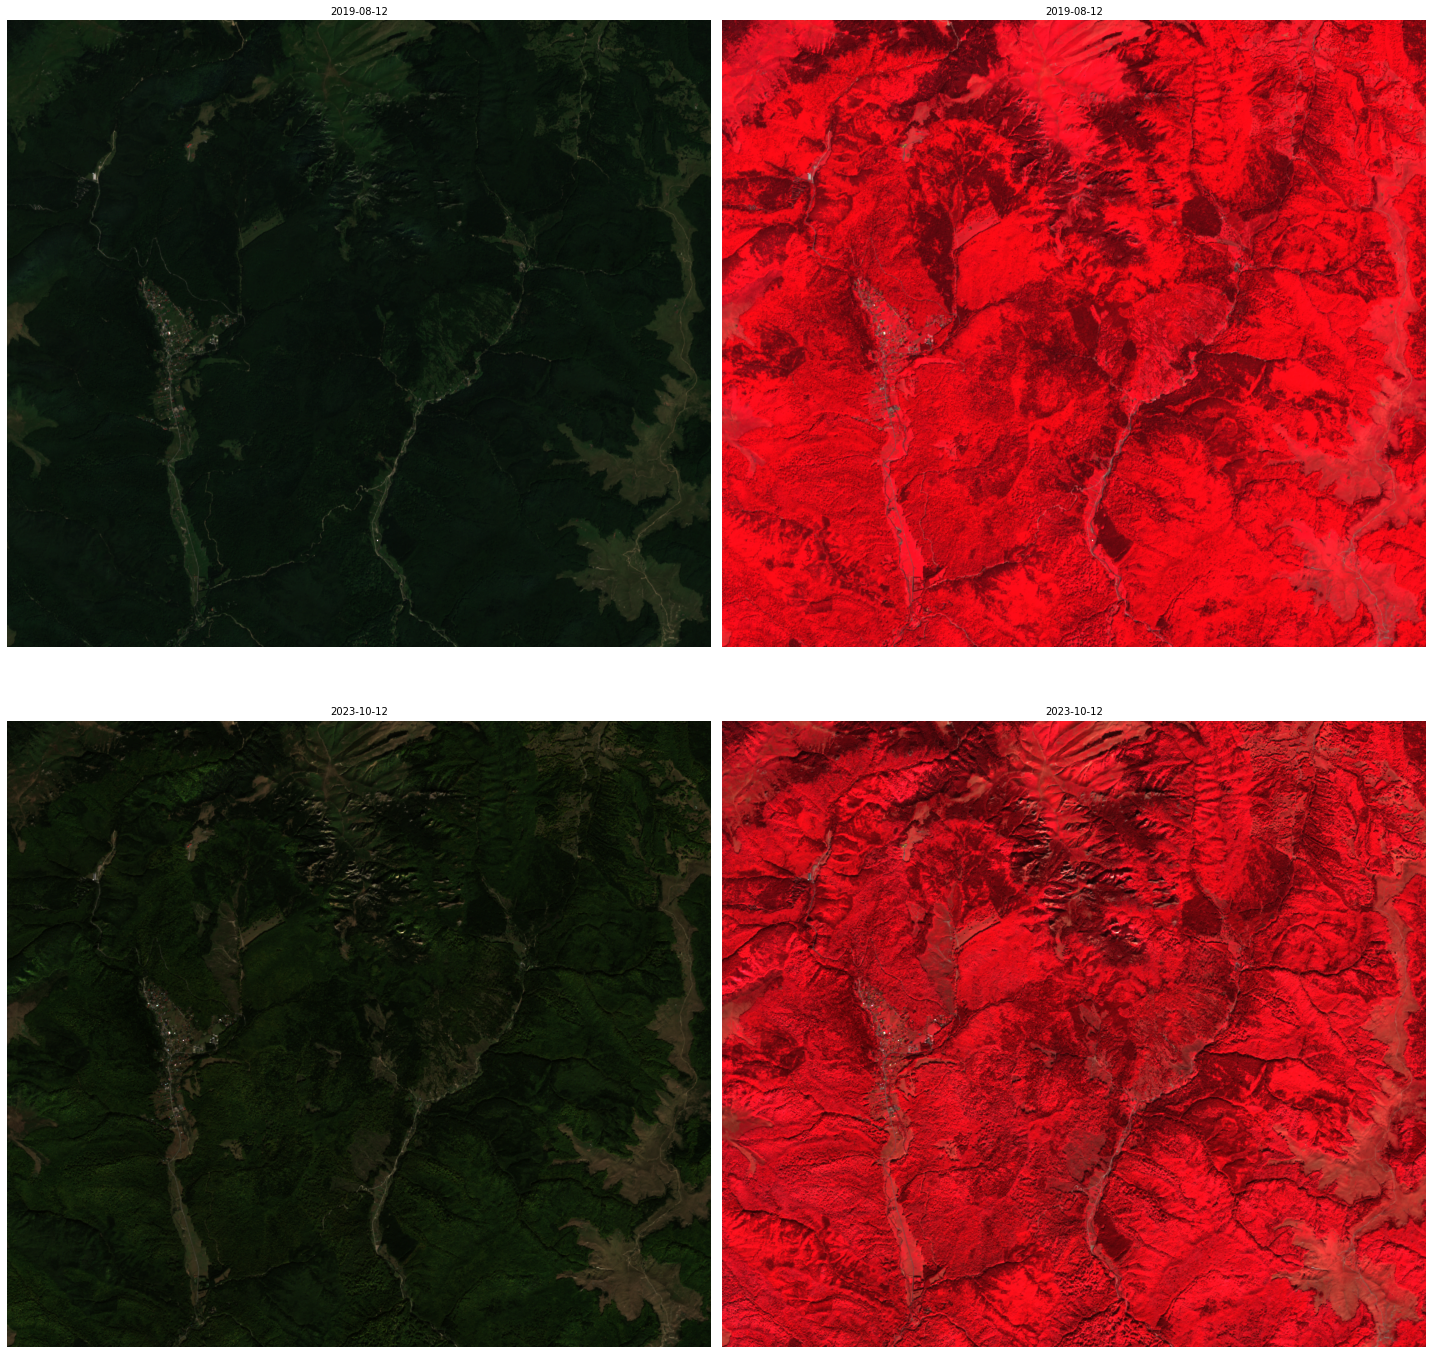

In [21]:
cheia_big = display_and_return_before_after(bbox=BBox((25.9,45.4071,26.0582,45.5087), crs=CRS.WGS84))

Total number of results: 43
Total number of results: 43


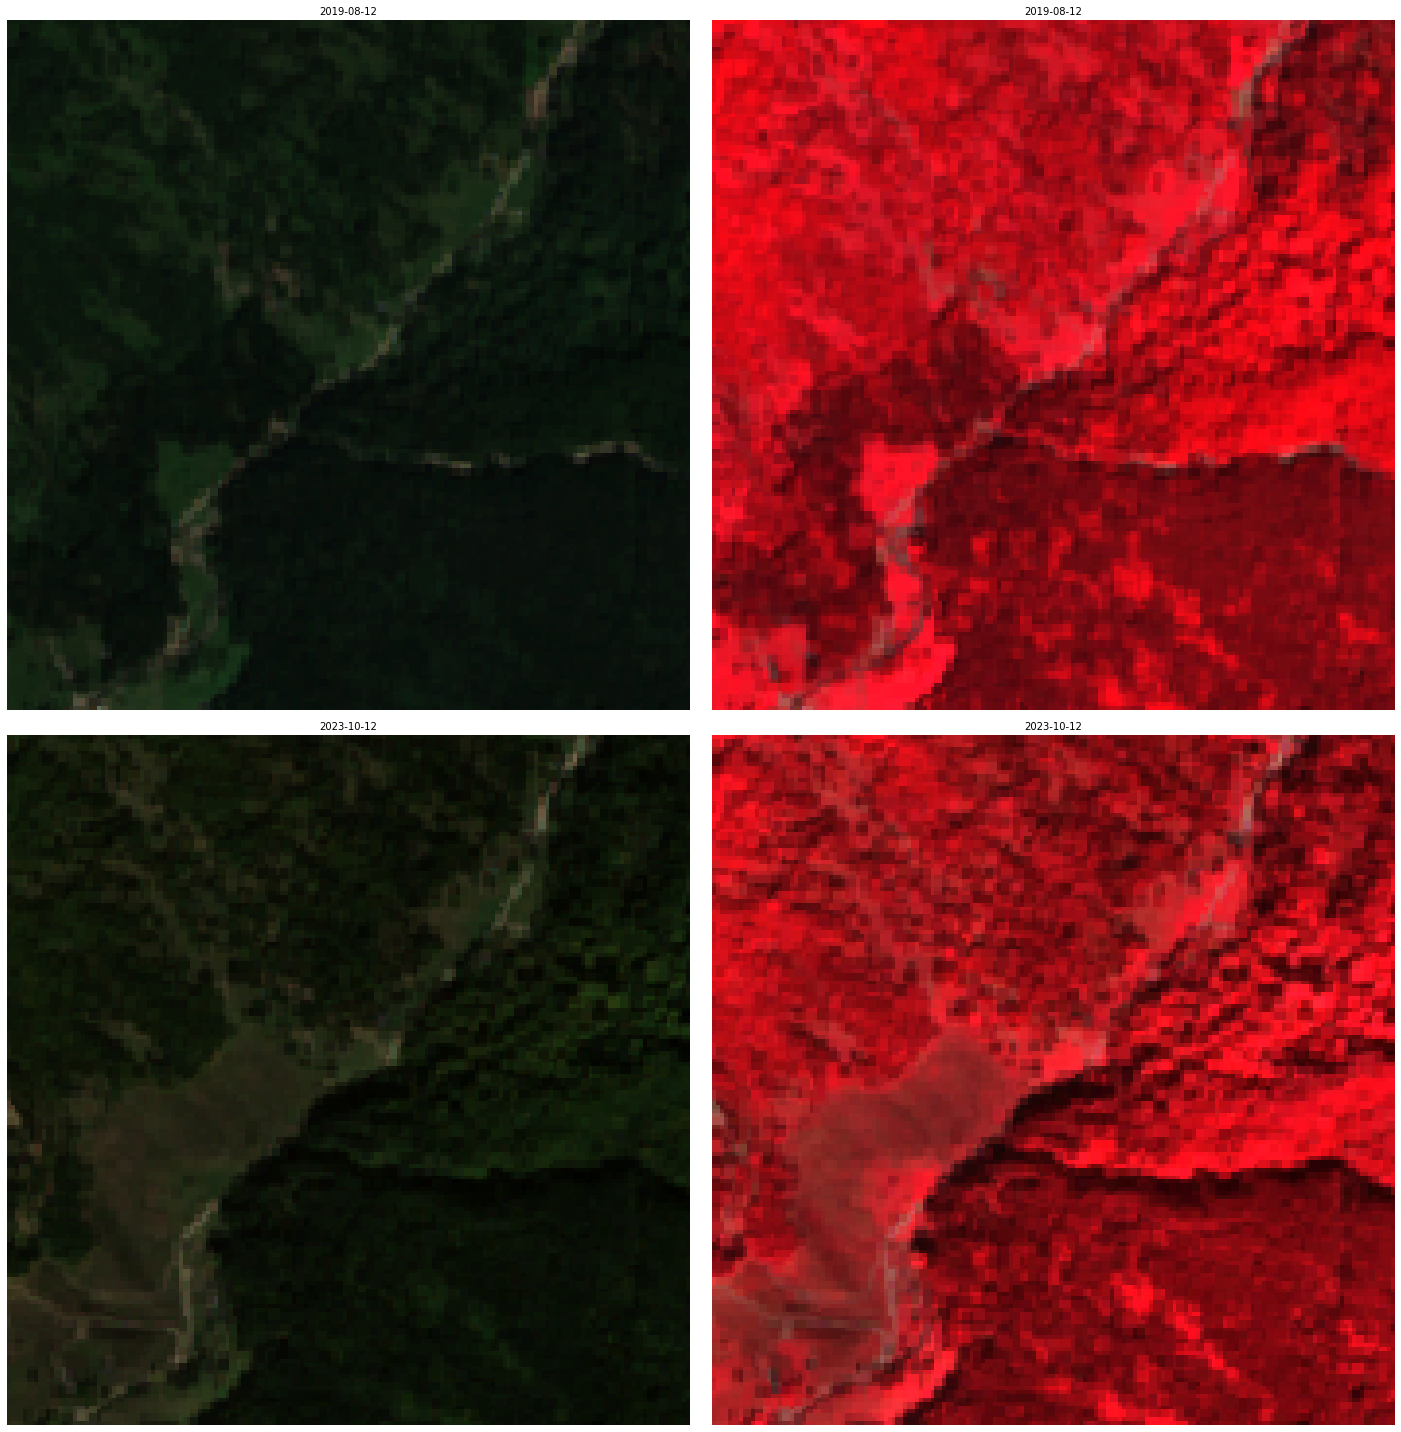

In [22]:
cheia_small_locally = display_and_return_before_after(bbox=BBox((26.0015,45.4506,26.017,45.4619), crs=CRS.WGS84))
